<a href="https://colab.research.google.com/github/ThanmaiJami/Object-Detection/blob/main/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Conditional GAN


## Import the required packages

In [ ]:
import cv2
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow_datasets as tfds
%matplotlib inline
from matplotlib import gridspec

## Data Loading and Pre Processing

In [ ]:
ds = tfds.load('RockPaperScissors', split='train', as_supervised=True, shuffle_files=True)
ds = ds.shuffle(1000).batch(128)
ds
@tf.function
def normalization(tensor):
    tensor = tf.image.resize(tensor, (128,128))
    tensor = tf.subtract(tf.divide(tensor, 127.5), 1)
    return tensor

In [ ]:
#Create dictionary of target classes
label_dict = {
 0: 'Rock',
 1: 'Paper',
 2: 'Scissors'
}

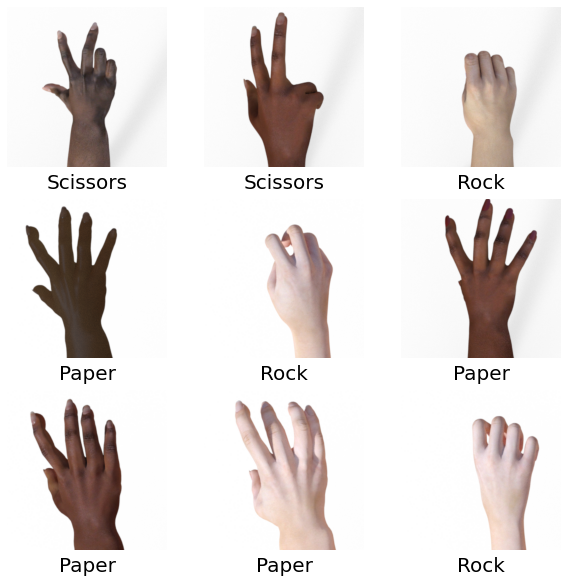

In [ ]:
#representing
plt.figure(figsize=(10, 10))
for image, label in ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        lab = np.array(label[i])
        plt.text(0.5, -0.1, s = label_dict[int(lab)], horizontalalignment='center',
     verticalalignment='center', transform = ax.transAxes, fontsize=20)
        plt.imshow(image[i])
        plt.axis("off")

In [ ]:
@tf.function
def normalization(tensor):
    #normalized_ds = data.map(lambda x: normalization_layer(x))
    tensor = tf.image.resize(
    tensor, (128,128))
    tensor = tf.subtract(tf.divide(tensor, 127.5), 1)
    return tensor
# image_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# print(np.min(first_image), np.max(first_image)) 

In [ ]:
for img, label in ds.take(1):
    img = tf.cast(img, tf.float32)
    imgs = normalization(img)
    print(imgs.shape)

(128, 128, 128, 3)


In [ ]:
BATCH_SIZE=128
latent_dim = 100

## Conditional Generator Implementation

In [ ]:
# label input
con_label = layers.Input(shape=(1,))
# latent vector input
latent_vector = layers.Input(shape=(100,))

In [ ]:
def label_conditioned_generator(n_classes=3, embedding_dim=100):
    # embedding for categorical input
    label_embedding = layers.Embedding(n_classes, embedding_dim)(con_label)
    #print(label_embedding)
    # linear multiplication
    nodes = 4 * 4
    label_dense = layers.Dense(nodes)(label_embedding)
    # reshape to additional channel
    label_reshape_layer = layers.Reshape((4, 4, 1))(label_dense)
    return label_reshape_layer

def latent_input(latent_dim=100):
    # image generator input
    nodes = 512 * 4 * 4
    latent_dense = layers.Dense(nodes)(latent_vector)
    latent_dense = layers.ReLU()(latent_dense)
    latent_reshape = layers.Reshape((4, 4, 512))(latent_dense)
    return latent_reshape

In [ ]:
# define the final generator model
def define_generator():
    latent_vector_output = label_conditioned_generator()
    label_output = latent_input()
    # merge label_conditioned_generator and latent_input output
    merge = layers.Concatenate()([latent_vector_output, label_output])

    x = layers.Conv2DTranspose(64 * 8, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_1')(merge)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1')(x)
    x = layers.ReLU(name='relu_1')(x)

    x = layers.Conv2DTranspose(64 * 4, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_2')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2')(x)
    x = layers.ReLU(name='relu_2')(x)

    x = layers.Conv2DTranspose(64 * 2, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_3')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_3')(x)
    x = layers.ReLU(name='relu_3')(x)

    x = layers.Conv2DTranspose(64 * 1, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_4')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_4')(x)
    x = layers.ReLU(name='relu_4')(x)

    out_layer = layers.Conv2DTranspose(3, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, activation='tanh', name='conv_transpose_6')(x)

   # define model
    model = tf.keras.Model([con_label, latent_vector], out_layer)
    return model

In [ ]:
conditional_gen = define_generator()

In [ ]:
conditional_gen.summary()#gives summary of the function define_generator

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 1, 100)       300         ['input_16[0][0]']               
                                                                                                  
 dense_14 (Dense)               (None, 8192)         827392      ['input_17[0][0]']               
                                                                                            

## Conditional Discriminator Implementation

In [ ]:
# label input
con_label = layers.Input(shape=(1,))

# input image
inp_img = layers.Input(shape=(128,128,3))

In [ ]:
def label_condition_disc(in_shape=(128,128,3), n_classes=3, embedding_dim=100):
    # label input
    con_label = layers.Input(shape=(1,))
    # embedding for categorical input
    label_embedding = layers.Embedding(n_classes, embedding_dim)(con_label)
    # scale up to image dimensions with linear activation
    nodes = in_shape[0] * in_shape[1] * in_shape[2]
    label_dense = layers.Dense(nodes)(label_embedding)
    # reshape to additional channel
    label_reshape_layer = layers.Reshape((in_shape[0], in_shape[1], 3))(label_dense)
    # image input
    return con_label, label_reshape_layer

def image_disc(in_shape=(128,128,3)):
    inp_image = layers.Input(shape=in_shape)
    return inp_image

In [ ]:
def define_discriminator():
    con_label, label_condition_output = label_condition_disc()
    inp_image_output = image_disc()
    # concat label as a channel
    merge = layers.Concatenate()([inp_image_output, label_condition_output])
    
    x = layers.Conv2D(64, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_1')(merge)
    x = layers.LeakyReLU(0.2, name='leaky_relu_1')(x)
    
    x = layers.Conv2D(64 * 2, kernel_size=4, strides= 3, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_2')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_2')(x)
    
    x = layers.Conv2D(64 * 4, 4, 3, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_3')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_3')(x)
      
    x = layers.Conv2D(64 * 8, 4, 3,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_5')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_4')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_5')(x)
 
    flattened_out = layers.Flatten()(x)
    # dropout
    dropout = layers.Dropout(0.4)(flattened_out)
    # output
    dense_out = layers.Dense(1, activation='sigmoid')(dropout)
    # define model
    model = tf.keras.Model([inp_image_output, con_label], dense_out)
    return model

In [ ]:
conditional_dis = define_discriminator()

In [ ]:
conditional_dis.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 1, 100)       300         ['input_20[0][0]']               
                                                                                                  
 dense_15 (Dense)               (None, 1, 49152)     4964352     ['embedding_9[0][0]']            
                                                                                                  
 input_21 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                          

In [ ]:
embeddings = conditional_gen.layers[3]
weights = embeddings.get_weights()[0]

In [ ]:
weights.shape

(100, 8192)

## Loss Function

In [ ]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

## Generator Loss

In [ ]:
def generator_loss(label, fake_output):
    gen_loss = binary_cross_entropy(label, fake_output)
    #print(gen_loss)
    return gen_loss

## Discriminator Loss

In [ ]:
def discriminator_loss(label, output):
    disc_loss = binary_cross_entropy(label, output)
    #print(total_loss)
    return disc_loss

## Optimizer

In [ ]:
learning_rate = 0.0002 
generator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )
discriminator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
num_examples_to_generate = 25
# We will reuse this seed overtime to visualize progress
seed = tf.random.normal([num_examples_to_generate, latent_dim])

In [ ]:
seed.dtype

tf.float32

In [ ]:
conditional_dis.input

[<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_21')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_20')>]

In [ ]:
conditional_gen.input

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_16')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'input_17')>]

## Training the Conditional GAN

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,target):
    # noise vector sampled from normal distribution
    noise = tf.random.normal([target.shape[0], latent_dim])
    # Train Discriminator with real labels
    with tf.GradientTape() as disc_tape1:
        generated_images = conditional_gen([noise,target], training=True)

        real_output = conditional_dis([images,target], training=True)
        real_targets = tf.ones_like(real_output)
        disc_loss1 = discriminator_loss(real_targets, real_output)

    # gradient calculation for discriminator for real labels
    gradients_of_disc1 = disc_tape1.gradient(disc_loss1, conditional_dis.trainable_variables)

    # parameters optimization for discriminator for real labels
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc1, conditional_dis.trainable_variables))

    # Train Discriminator with fake labels
    with tf.GradientTape() as disc_tape2:
        fake_output = conditional_dis([generated_images,target], training=True)
        fake_targets = tf.zeros_like(fake_output)
        disc_loss2 = discriminator_loss(fake_targets, fake_output)
    # gradient calculation for discriminator for fake labels
    gradients_of_disc2 = disc_tape2.gradient(disc_loss2, conditional_dis.trainable_variables)

    # parameters optimization for discriminator for fake labels
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc2, conditional_dis.trainable_variables))

    # Train Generator with real labels
    with tf.GradientTape() as gen_tape:
        generated_images = conditional_gen([noise,target], training=True)
        fake_output = conditional_dis([generated_images,target], training=True)
        real_targets = tf.ones_like(fake_output)
        gen_loss = generator_loss(real_targets, fake_output)

    # gradient calculation for generator for real labels
    gradients_of_gen = gen_tape.gradient(gen_loss, conditional_gen.trainable_variables)

    # parameters optimization for generator for real labels
    generator_optimizer.apply_gradients(zip(gradients_of_gen, conditional_gen.trainable_variables)) 

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        D_loss_list, G_loss_list = [], []
        for image_batch,target in dataset:
            i += 1
            img = tf.cast(image_batch, tf.float32)
            imgs = normalization(img)
            train_step(imgs,target)
        print(epoch)        
        display.clear_output(wait=True)
        generate_and_save_images(conditional_gen,
                              epoch + 1,
                              seed)

#         # Save the model every 15 epochs
#         if (epoch + 1) % 15 == 0:
#             checkpoint.save(file_prefix = checkpoint_prefix)

        conditional_gen.save_weights('rock-paper-scissors/training_weights/gen_'+ str(epoch)+'.h5')
        conditional_dis.save_weights('rock-paper-scissors/training_weights/disc_'+ str(epoch)+'.h5')    
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(conditional_gen,
                            epochs,
                            seed)

In [ ]:
def label_gen(n_classes):
    lab = tf.random.uniform((1,), minval=0, maxval=n_classes, dtype=tf.dtypes.int32, seed=None, name=None)
    return tf.repeat(lab, [25], axis=None, name=None)

In [ ]:
# Create dictionary of target classes
label_dict = {
 0: 'Rock',
 1: 'Paper',
 2: 'Scissors'
}

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    labels = label_gen(n_classes=3)
    predictions = model([test_input, labels], training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(8,8))

    print("Generated Images are Conditioned on Label:", label_dict[np.array(labels)[0]])
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        pred = (predictions[i, :, :, :] + 1 ) * 127.5
        pred = np.array(pred)  
        plt.imshow(pred.astype(np.uint8))
        plt.axis('off')

    plt.savefig('rock-paper-scissors/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

In [ ]:
train(ds, 100)

ValueError: ignored

In [ ]:
conditional_gen.load_weights('rock-paper-scissors/training_weights/gen_99.h5')

OSError: ignored

## Results

In [ ]:
def generate_images(model, test_input, n_classes=3):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    output = None
    for label in range(n_classes):
        labels = tf.ones(10) * label
        predictions = model([labels, test_input], training=False)
        if output is None:
            output = predictions
        else:
            output = np.concatenate((output,predictions))

    nrow = 3
    ncol = 10
    fig = plt.figure(figsize=(25,25))
    gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1, 1, 1,1, 1,1, 1, 1, 1, 1], wspace=0.0, hspace=0.0, top=0.2, bottom=0.00, left=0.17, right=0.845) 
    label_dict[np.array(labels)[0]]
    k = 0
    for i in range(nrow):
        for j in range(ncol):
            pred = (output[k, :, :, :] + 1 ) * 127.5
            pred = np.array(pred)
            ax= plt.subplot(gs[i,j])
            ax.imshow(pred.astype(np.uint8))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.axis('off')
            k += 1  

    plt.show()

In [ ]:
num_examples_to_generate = 10
latent_dim = 100
n_classes = 3
noise = tf.random.normal([num_examples_to_generate, latent_dim])

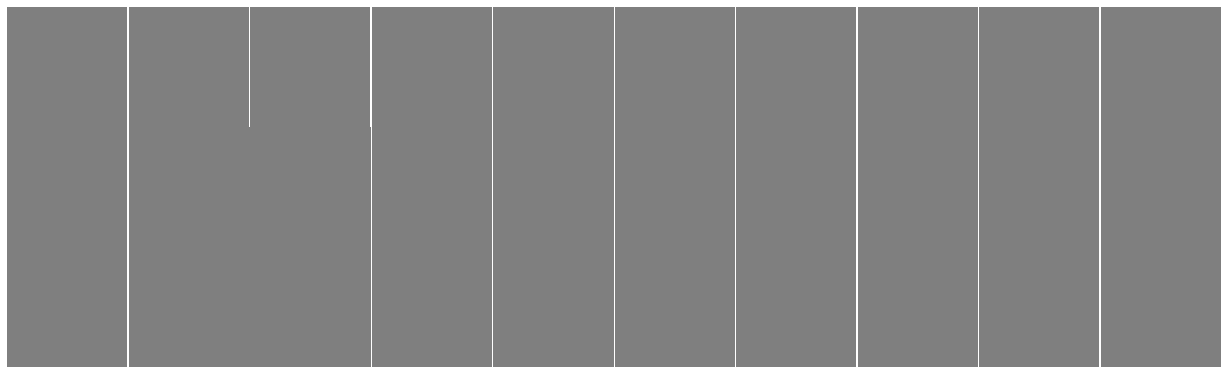

In [ ]:
generate_images(conditional_gen, noise,  n_classes)